# Predicting 311 Noise Complaints Using ARIMA

#### Posted on [Brunchline](http://www.brunchline.co) by [@DQOfficial](http://www.github.com/dqofficial)

In [79]:
# import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults, ARIMAResults
from matplotlib.pyplot import acorr
import sys
print sys.version
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
%pylab inline

2.7.11 (default, Dec  5 2015, 14:44:47) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)]
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [80]:
# read in data from NYC Open Data
# since the 311 dataset is massive, i filtered it to two years and only noise complaints, then stored locally
df = pd.read_csv('311_noise_since_jul14.csv')
# set our created date to a datetime object
#df['Created Date']=pd.to_datetime(df['Created Date'])
print len(df)

778809


In [81]:
# let's take a look at the column headings
df.columns

Index([u'Unique Key', u'Created Date', u'Closed Date', u'Agency',
       u'Agency Name', u'Complaint Type', u'Descriptor', u'Location Type',
       u'Incident Zip', u'Incident Address', u'Street Name', u'Cross Street 1',
       u'Cross Street 2', u'Intersection Street 1', u'Intersection Street 2',
       u'Address Type', u'City', u'Landmark', u'Facility Type', u'Status',
       u'Due Date', u'Resolution Description',
       u'Resolution Action Updated Date', u'Community Board', u'Borough',
       u'X Coordinate (State Plane)', u'Y Coordinate (State Plane)',
       u'Park Facility Name', u'Park Borough', u'School Name',
       u'School Number', u'School Region', u'School Code',
       u'School Phone Number', u'School Address', u'School City',
       u'School State', u'School Zip', u'School Not Found',
       u'School or Citywide Complaint', u'Vehicle Type',
       u'Taxi Company Borough', u'Taxi Pick Up Location',
       u'Bridge Highway Name', u'Bridge Highway Direction', u'Road Ramp',

In [82]:
# let's pick out the descriptors that might relate to loud neighbors
df['Descriptor'].unique()

array(['Loud Music/Party', 'Car/Truck Music', 'Loud Talking',
       'Noise: air condition/ventilation equipment (NV1)',
       'Noise: Construction Before/After Hours (NM1)',
       'Noise, Barking Dog (NR5)', 'Noise: Private Carting Noise (NQ1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)', 'Engine Idling',
       'Noise: Alarms (NR3)', 'Other', 'Car/Truck Horn',
       'Noise: Boat(Engine,Music,Etc) (NR10)', 'Banging/Pounding',
       'Noise: Loud Music/Nighttime(Mark Date And Time) (NP1)',
       'Noise, Ice Cream Truck (NR4)', 'Noise:  lawn care equipment (NCL)',
       'Loud Television', '21 Collection Truck Noise', 'NYPD',
       'Noise, Other Animals (NR6)', 'News Gathering',
       'Noise: Manufacturing Noise (NK1)',
       'Noise: Other Noise Sources (Use Comments) (NZZ)',
       'Noise: Loud Music/Daytime (Mark Date And Time) (NN1)',
       'Noise: Air Condition/Ventilation Equip, Commercial (NJ2)',
       'Noise: Vehicle (NR2)'], dtype

In [83]:
# store the relevant ones in a list
complaint_list = ['Loud Music/Party','Banging/Pounding','Loud Talking',
                  'Noise: Loud Music/Daytime (Mark Date And Time) (NN1)',
                   'Noise: Loud Music/Nighttime(Mark Date And Time) (NP1)']

In [84]:
# create a function to manipulate our data into a usable format. this function will help us later on.

def data_prep(df):
    df['Created Date']=pd.to_datetime(df['Created Date'])
    df['noise_flag']=df.Descriptor.isin(complaint_list)
    df = df.loc[df.noise_flag==True]
    my_list = df['Created Date']
    df['date'] = df['Created Date'].apply(lambda x: x.date())
    return df


In [85]:
df = data_prep(df)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [86]:
df.columns

Index([u'Unique Key', u'Created Date', u'Closed Date', u'Agency',
       u'Agency Name', u'Complaint Type', u'Descriptor', u'Location Type',
       u'Incident Zip', u'Incident Address', u'Street Name', u'Cross Street 1',
       u'Cross Street 2', u'Intersection Street 1', u'Intersection Street 2',
       u'Address Type', u'City', u'Landmark', u'Facility Type', u'Status',
       u'Due Date', u'Resolution Description',
       u'Resolution Action Updated Date', u'Community Board', u'Borough',
       u'X Coordinate (State Plane)', u'Y Coordinate (State Plane)',
       u'Park Facility Name', u'Park Borough', u'School Name',
       u'School Number', u'School Region', u'School Code',
       u'School Phone Number', u'School Address', u'School City',
       u'School State', u'School Zip', u'School Not Found',
       u'School or Citywide Complaint', u'Vehicle Type',
       u'Taxi Company Borough', u'Taxi Pick Up Location',
       u'Bridge Highway Name', u'Bridge Highway Direction', u'Road Ramp',

In [87]:
# # filter 
# df['noise_flag']=df.Descriptor.isin(complaint_list)
# df = df[df.noise_flag==True]

In [88]:
# strip the date part of the datetime object out
# df['date'] = df['Created Date'].apply(lambda x: x.date())

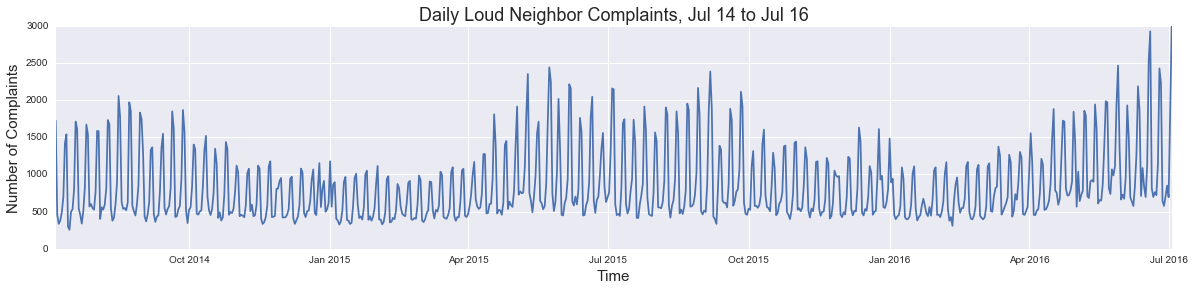

In [89]:
# group by day, then group by week
noise_df= pd.DataFrame({'count':df.noise_flag.groupby(df.date).sum()})
noise_df['count'].astype(int)


fig, ax = plt.subplots(figsize=(20,4))
plt.subplot(111)
plt.plot(noise_df['count'])
plt.title('Daily Loud Neighbor Complaints, Jul 14 to Jul 16',fontsize = 18)
plt.ylabel('Number of Complaints', fontsize =15)
plt.xlabel('Time', fontsize =15)

In [90]:
# resample the data to be weekly in order to move day of week periodicity
noise_series = pd.date_range(noise_df.index.min(),noise_df.index.max(),freq='W')
# then create the series we will use for the rest of the analysis
noises = pd.Series(noise_df['count'],index=noise_series)
noises = noises[:-1] # dropping the last week because the July 4th holiday messes everything up :(
noises.tail()

2016-05-29    2462
2016-06-05    1488
2016-06-12    1862
2016-06-19    2923
2016-06-26    2224
Freq: W-SUN, Name: count, dtype: float64

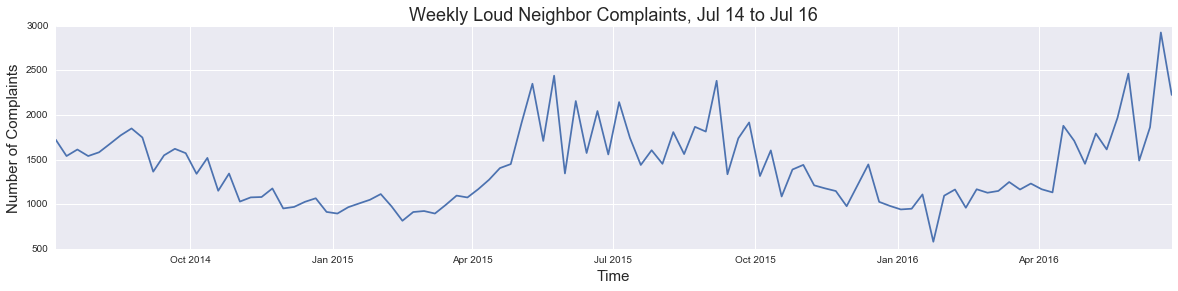

In [91]:
fig, ax = plt.subplots(figsize=(20,4))
plt.subplot(111)
plt.plot(noises)
plt.title('Weekly Loud Neighbor Complaints, Jul 14 to Jul 16',fontsize = 18)
plt.ylabel('Number of Complaints', fontsize =15)
plt.xlabel('Time', fontsize =15)

In [92]:
# create the name variable so we don't always have to type it out
name = 'Weekly Noise Complaints'

In [93]:
# rename the dataframe 'data' so it's easier
data = pd.DataFrame({'complaints':noises})
data.complaints.astype(float)
#data.rename({'index':'date'},inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104 entries, 2014-07-06 to 2016-06-26
Freq: W-SUN
Data columns (total 1 columns):
complaints    104 non-null float64
dtypes: float64(1)
memory usage: 1.6 KB


In [94]:
data['log'] = np.log(data.complaints)
data['diff_log'] = data.log - data.log.shift(periods=-1)
data = data.dropna()
data.head()

,complaints,log,diff_log
2014-07-06,1723,7.451822,0.112934
2014-07-13,1539,7.338888,-0.046343
2014-07-20,1612,7.385231,0.046343
2014-07-27,1539,7.338888,-0.026925
2014-08-03,1581,7.365813,-0.057756


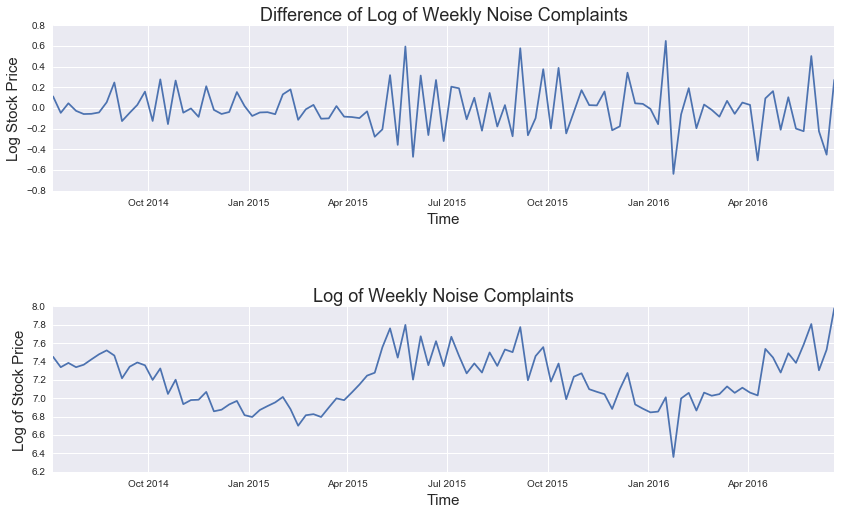

In [95]:
fig, ax = plt.subplots(figsize = (14,8))
fig.subplots_adjust(hspace=.7)

plt.subplot(211)
plt.plot(data.diff_log)
plt.title('Difference of Log of %s' % name, fontsize = 18)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Log Stock Price', fontsize = 15)

plt.subplot(212)
plt.plot(data.log)
plt.title('Log of %s' % name, fontsize = 18)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Log of Stock Price', fontsize = 15)

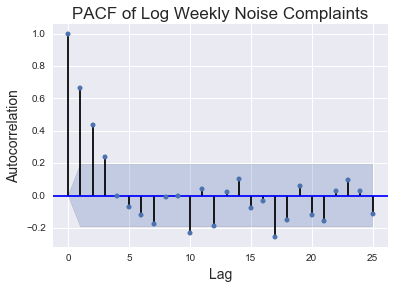

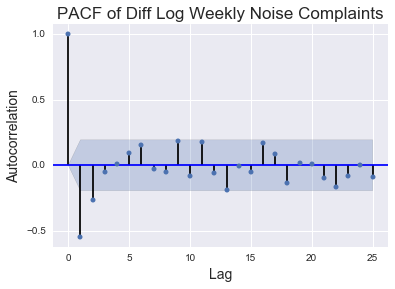

In [96]:
# plot the PACF
plot_pacf(data.log, lags = 25)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('PACF of Log %s' % name, fontsize = 17)

plot_pacf(data.diff_log, lags = 25)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('PACF of Diff Log %s' % name, fontsize = 17)

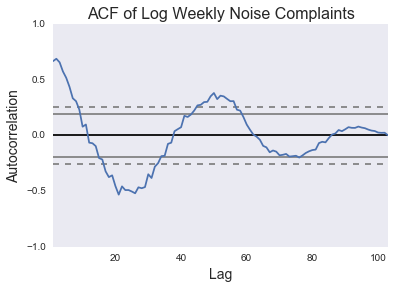

In [97]:
# then plot the ACF of log rupee
autocorrelation_plot(data.log)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('ACF of Log %s' % name, fontsize= 16)

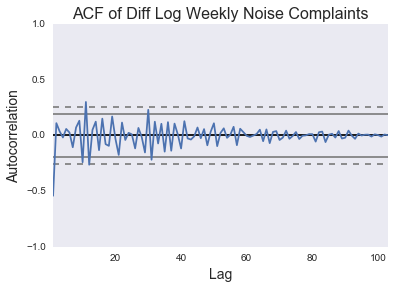

In [98]:
# then plot the ACF of the diff log
autocorrelation_plot(data.diff_log)
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.title('ACF of Diff Log %s' % name, fontsize= 16)

In [99]:
#Perform Dickey-Fuller test:
print 'Results of Dickey-Fuller Test:'
dftest = adfuller(data.diff_log, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
   dfoutput['Critical Value (%s)'%key] = value
print dfoutput

Results of Dickey-Fuller Test:
Test Statistic                -1.132328e+01
p-value                        1.159960e-20
# Lags Used                    1.000000e+00
Number of Observations Used    1.010000e+02
Critical Value (5%)           -2.890611e+00
Critical Value (1%)           -3.496818e+00
Critical Value (10%)          -2.582277e+00
dtype: float64


### Since our test statistic is lower than our 1% critical value, we can say we are 99% certain that the time series is now stationary

# Next Step: Model Selection

In [100]:
ararray = (data.log.dropna().as_matrix())

p=0
q=0
d=0
pdq=[]
aic=[]

for p in range(3):
    for q in range(3):
            try:
                model = ARIMA(ararray, (p,d,q)).fit()
                x = model.aic
                x1 = (p,d,q)
                #print (x1, x)
                aic.append(x)
                pdq.append(x1)
            except:
                pass

keys = pdq
values = aic
d = dict(zip(keys, values))

minaic=min(d, key=d.get)

for i in range(3):
    p=minaic[0]
    d=minaic[1]
    q=minaic[2]

print 'The model with the lowest AIC score of %s' % np.round(x,4)
print 'Best described with an ARIMA(',p,d,q,') model'

The model with the lowest AIC score of -53.4878
Best described with an ARIMA( 2 0 2 ) model


In [101]:
# now let's fit the model we selected above
model = ARIMA(ararray, (p,d,q)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  103
Model:                     ARMA(2, 2)   Log Likelihood                  32.744
Method:                       css-mle   S.D. of innovations              0.175
Date:                Tue, 12 Jul 2016   AIC                            -53.488
Time:                        15:24:17   BIC                            -37.679
Sample:                             0   HQIC                           -47.085
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          7.2511      0.106     68.411      0.000         7.043     7.459
ar.L1.y        1.7038      0.203      8.402      0.000         1.306     2.101
ar.L2.y       -0.7380      0.192     -3.840      0.0

In [102]:
# calculate the residuals (or errors)
prediction = pd.DataFrame(data.log) # use data.log[:1] if forcing to ARIMA(P,1,Q)
prediction['predict'] = np.exp(model.predict())
prediction['residuals'] = prediction.log - prediction.predict
prediction.head()

,log,predict,residuals
2014-07-06,7.451822,1409.622828,-1402.171006
2014-07-13,7.338888,1631.916688,-1624.577800
2014-07-20,7.385231,1592.221032,-1584.835801
2014-07-27,7.338888,1587.013064,-1579.674176
2014-08-03,7.365813,1559.140392,-1551.774579


In [126]:
# calculate 1 step ahead forecast
numofsteps = 1
stepahead = model.forecast(numofsteps)[0]
ferrors = model.forecast(numofsteps)[2]

print'%s Step ahead forecast value is:' % numofsteps, np.exp(stepahead)
print '%s Step ahead 95 percent CI is:' % numofsteps, np.exp(ferrors)

1 Step ahead forecast value is: [ 2048.5895823]
1 Step ahead 95 percent CI is: [[ 1454.79658368  2884.74644759]]


In [104]:
# save the one step ahead value to be added to our large datafrae later 
idx=pd.to_datetime('2016-07-03')
forecast=pd.DataFrame({'forecast':np.exp(stepahead),'idx':idx})
forecast.set_index('idx',inplace=True)
forecast

,forecast
idx,
2016-07-03,2048.589582


In [105]:
noises=noises.append(pd.Series(int(forecast.iloc[0,0]),index=forecast.index))
noises.tail()

2016-06-05    1488
2016-06-12    1862
2016-06-19    2923
2016-06-26    2224
2016-07-03    2048
dtype: float64

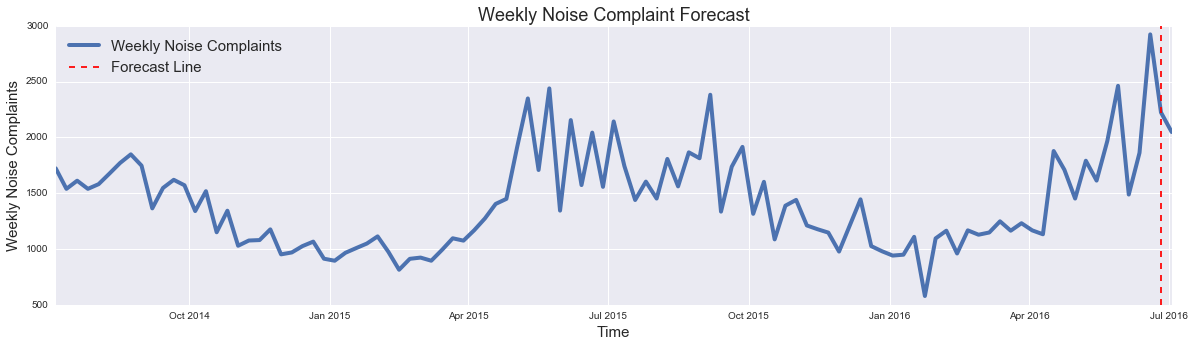

In [127]:
# plot the forecast, using a dotted red line to show our forecast cutoff
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(noises, linewidth=4,label='Weekly Noise Complaints')
plt.axvline('2016-06-26',color='red',linestyle='dashed', label='Forecast Line')
plt.title('Weekly Noise Complaint Forecast', fontsize=18)
plt.ylabel('Weekly Noise Complaints', fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.legend(loc=2,fontsize=15)

In [107]:
noises.iloc[-3:-1]

2016-06-19    2923
2016-06-26    2224
dtype: float64

In [108]:
test = pd.DataFrame({'actual':noises})
fcast = pd.DataFrame({'fcast':noises.iloc[-2:]})
test=test.append(fcast)

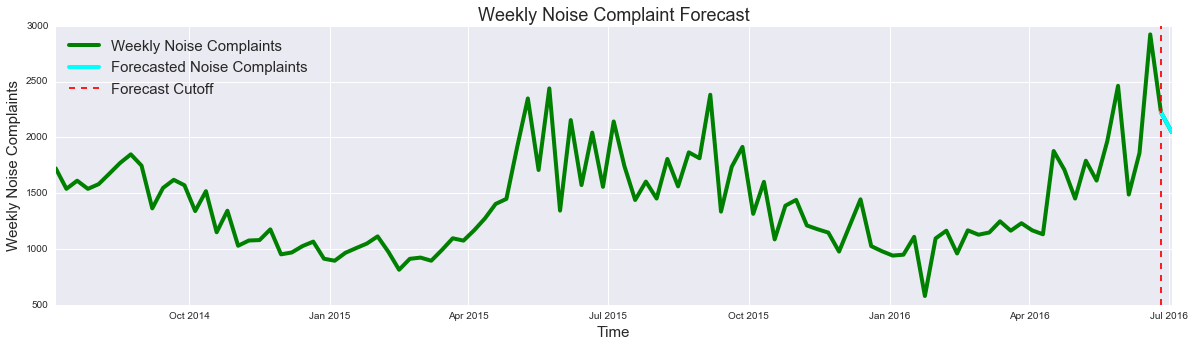

In [120]:
# this is a better plot that shows where we switch from actuals to forecast
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(test.actual, linewidth=4,label='Weekly Noise Complaints', c='green')
plt.plot(test.fcast, linewidth=4,label='Forecasted Noise Complaints',c='cyan')
plt.axvline('2016-06-26',color='red',linestyle='dashed', label='Forecast Cutoff')
plt.title('Weekly Noise Complaint Forecast', fontsize=18)
plt.ylabel('Weekly Noise Complaints', fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.legend(loc=2,fontsize=15)